แผนที่ที่เราใช้กันอยู่ทุกวันนี้ คือการฉายภาพของพื้นผิวโลกลงบนพื้นที่ 2 มิติ เหมือนแผ่นกระดาษ แต่โลกของเราจริง ๆ แล้วเป็นทรงกลม 3 มิติ เหมือนผลส้ม ดังนั้นเราจึงต้องมีวิธีการเรียกว่า Map Projection เพื่อ Render พื้นผิวโค้ง 3 มิติ แปลงให้เป็นพื้นผิวเรียบ 2 มิติ

เนื่องจากเป็นการแปลง 3 มิติเป็น 2 มิติ จะต้องมีข้อมูลสูญหายไประหว่างทาง อย่างแน่นอน Map Projection แต่ละแบบก็จะบิด Distort พื้นผิวโลก ด้วยวิธีที่แตกต่างกัน ทำให้ไม่มี Projection ไหนที่ดีที่สุด แต่ละแบบจะมีข้อดีข้อเสียแตกต่างกัน เช่น

* Equal-Area Projection (เช่น Lambert Cylindrical Equal Area, หรือ Africa Albers Equal Area Conic) จะเน้นคงขนาดพื้นที่ เหมาะสำหรับใช้ในการคำนวนพื้นที่จังหวัด พื้นที่ของประเทศ เป็นต้น

* Equidistant Projection (เช่น Azimuthal Equidistant Projection) จะเน้นคงขนาดระยะทาง เหมาะสำหรับใช้คำนวนระยะทาง เช่น วัดระยะทางในเส้นทางการบินข้ามประเทศ

เราใช้ Coordinate Reference System (CRS) ในการแสดงภาพฉายของข้อมูลพิกัดภูมิศาสตร์ ใน Projection ที่กำหนด ลงบนพื้นผิวโลก ใน ep นี้เราจะเรียนรู้การใช้งาน CRS แบบต่าง ๆ ด้วย GeoPandas


# 0. Install

เราจะต้อง Install kaggle เพื่อ Download Dataset และ geopandas เพื่อใช้ในการวิเคราะห์ข้อมูล geospatial (ถ้ายังไม่ได้ Install ให้ uncomment)

In [1]:
! pip install geopandas
! pip install kaggle --upgrade

     |████████████████████████████████| 921kB 6.3MB/s 
     |████████████████████████████████| 11.9MB 22.7MB/s 
     |████████████████████████████████| 10.1MB 36.4MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=f9c030fa4a8c848618549576c6257f65db7bb41b60a504d049c2b83ec1a8ff8a
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


# 1. Mount Google Drive

กำหนด path ของ Config File และ Dataset

In [0]:
config_path = '/content/drive'
dataset = 'alexisbcook/geospatial-learn-course-data'
data_path = '/content/datasets/' + dataset

Mount Google Drive เพื่อดึง Config File มาจาก Google Drive ส่วนตัวของเรา เมื่อเรารัน Cell ด้านล่างจะมีลิงค์ปรากฎขึ้นมาให้เรา Login กด Approve แล้ว Copy Authorization Code มาใส่ในช่องด้านล่าง แล้วกด Enter

In [3]:
from google.colab import drive
drive.mount(config_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# 2. Download Dataset

กำหนด Environment Variable ไปยังโฟลเดอร์ที่เก็บ kaggle.json

In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = f"{config_path}/My Drive/.kaggle"

สั่งดาวน์โหลด Dataset พร้อมทั้ง unzip ไว้ใน data_path

In [5]:
!kaggle datasets download {dataset} -p "{data_path}" --unzip

100% 233M/233M [00:05<00:00, 51.8MB/s]
100% 233M/233M [00:05<00:00, 47.2MB/s]


# 3. Import Library

Import geopandas Library เพื่อใช้ในการวิเคราะห์ข้อมูล geospatial ตั้งชื่อเล่นเป็น gpd

In [0]:
import pandas as pd
import geopandas as gpd

from shapely.geometry import LineString

# 4. Data

ใน ep นี้ เราจะสมมติตัวเองว่าเป็นนักอนุรักษ์พันธุ์นก ที่ต้องการศึกษาการอพยพย้ายถิ่นของนกพันธุ์ Purple Martins ที่มีพฤติกรรม สืบพันธุ์ในฤดูร้อน ในภาคตะวันออกของสหรัฐอเมริกา และอพยพลงสู่อเมริกาใต้เมื่อเข้าสู่ฤดูหนาว เนื่องจากนกพันธุ์นี้อยู่ในรายการสัตว์ใกล้สูญพันธุ์ เราจะมาวิเคราะห์พฤติกรรม เจาะลึกถึงตำแหน่งพื้นที่ ที่นกอาศัยในช่วงเวลาต่าง ๆ ว่าได้เข้าไปในเขตรักษาพันธุ์สัตว์ป่า ในพื้นที่ที่ได้จัดไว้ให้หรือไม่

เราจะ Load CSV ข้อมูลเส้นทางการเดินทางของ นก 11 ตัว ขึ้นมาจาก Dataset ดูจาก tag-local-identifier คือรหัสประจำตัวของนก

In [7]:
birds_df = pd.read_csv(f"{data_path}/purple_martin.csv", parse_dates=['timestamp'])
print("There are {} different birds in the dataset.".format(birds_df["tag-local-identifier"].nunique()))
birds_df.head()

There are 11 different birds in the dataset.


,timestamp,location-long,location-lat,tag-local-identifier
0,2014-08-15 05:56:00,-88.146014,17.513049,30448
1,2014-09-01 05:59:00,-85.243501,13.095782,30448
2,2014-10-30 23:58:00,-62.906089,-7.852436,30448
3,2014-11-15 04:59:00,-61.776826,-11.723898,30448
4,2014-11-30 09:59:00,-61.241538,-11.612237,30448


สร้าง GeoDataFrame ขึ้นมาด้วย gpd.points_from_xy จาก Latitude และ Longitude ใน CSV และเนื่องจากเป็น CSV ไม่มี CRS มาด้วย เราต้องกำหนดเอง ด้วย {'init': 'epsg:4326'}

In [0]:
birds = gpd.GeoDataFrame(birds_df, geometry=gpd.points_from_xy(birds_df['location-long'], birds_df['location-lat']))

birds.crs = {'init': 'epsg:4326'}

โหลดแผนที่โลกขึ้นมา กรองเอาเฉพาะทวีปอเมริกา

In [9]:
# Load a GeoDataFrame with country boundaries in North/South America, print the first 5 rows
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
americas = world.loc[world['continent'].isin(['North America', 'South America'])]
americas.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
16,10646714,North America,Haiti,HTI,19340.0,"POLYGON ((-71.71236 19.71446, -71.62487 19.169..."


# 5. Plot

พล็อตแผนที่ประเทศในทวีปอเมริกา และตำแหน่งพิกัดที่พบนก Purple Martins

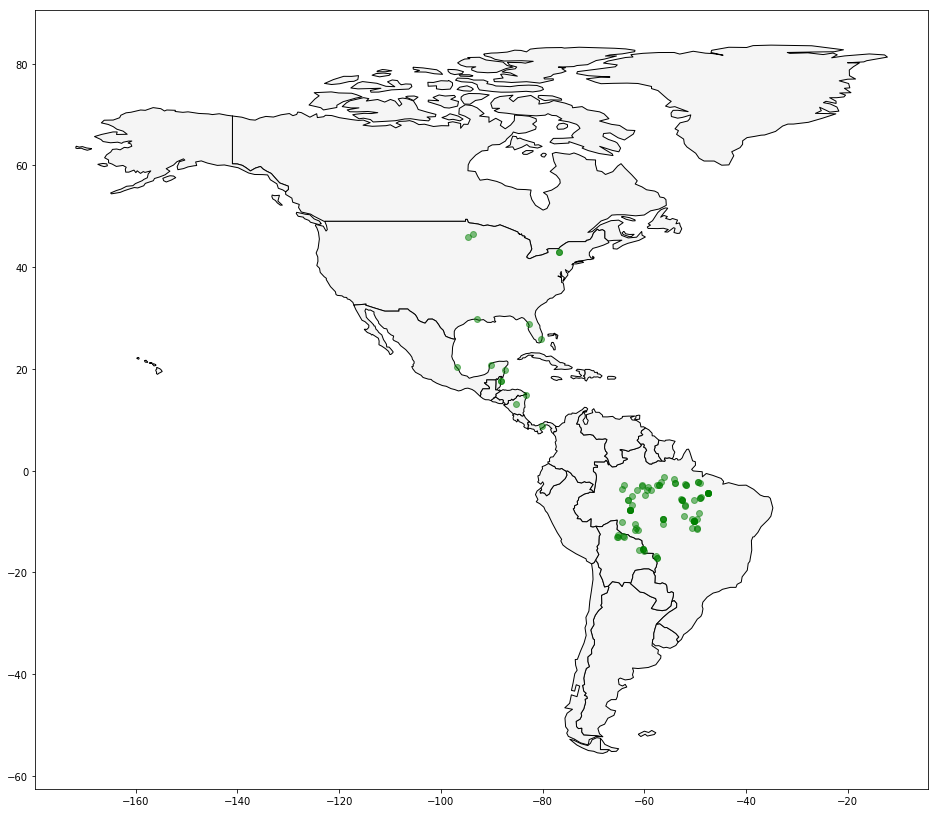

In [10]:
ax = americas.plot(color='whitesmoke', edgecolor='black', figsize=(16, 16))
birds.plot(color='green', alpha=0.5, ax=ax)

# 6. เชื่อมโยงข้อมูล

สร้าง GeoDataFrame เส้นทาง LineString การเดินทางของนก Purple Martins แต่ละตัว

In [12]:
path_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: LineString(x)).reset_index()
path_gdf = gpd.GeoDataFrame(path_df, geometry=path_df.geometry)
path_gdf.crs = {'init' :'epsg:4326'}
path_gdf.head()

,tag-local-identifier,geometry
0,30048,"LINESTRING (-90.12992 20.73242, -56.29394 -10...."
1,30054,"LINESTRING (-93.60861 46.50563, -63.28897 -5.7..."
2,30198,"LINESTRING (-80.31036 25.92545, -88.14608 17.5..."
3,30263,"LINESTRING (-76.78146 42.99209, -62.90648 -7.8..."
4,30275,"LINESTRING (-76.78213 42.99207, -60.26131 -15...."


สร้าง GeoDataFrame จุดเริ่มการเดินทางของนก Purple Martins แต่ละตัว

In [0]:
start_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[0]).reset_index()
start_gdf = gpd.GeoDataFrame(start_df, geometry=start_df.geometry)
start_gdf.crs = {'init' :'epsg:4326'}

In [14]:
start_gdf.head()

,tag-local-identifier,geometry
0,30048,POINT (-90.12992 20.73242)
1,30054,POINT (-93.60861 46.50563)
2,30198,POINT (-80.31036 25.92545)
3,30263,POINT (-76.78146 42.99209)
4,30275,POINT (-76.78213 42.99207)


สร้าง GeoDataFrame จุดสิ้นสุดการเดินทางของนก Purple Martins แต่ละตัว

In [24]:
end_df = birds.groupby("tag-local-identifier")['geometry'].apply(list).apply(lambda x: x[-1]).reset_index()
end_gdf = gpd.GeoDataFrame(end_df, geometry=end_df.geometry)
end_gdf.crs = {'init' :'epsg:4326'}
end_gdf.head()

,tag-local-identifier,geometry
0,30048,POINT (-47.53632 -4.43758)
1,30054,POINT (-62.47914 -5.03840)
2,30198,POINT (-57.46417 -2.77617)
3,30263,POINT (-50.19230 -5.70504)
4,30275,POINT (-57.70404 -16.72336)


นำ GeoDataFrame ที่เราสร้างด้านบน มาพล็อต จุดเริ่ม (สีเขียว) เส้นทาง (สีส้ม) จุดสิ้นสุด (สีแดง) ของการเดินทางของนก Purple Martins แต่ละตัว

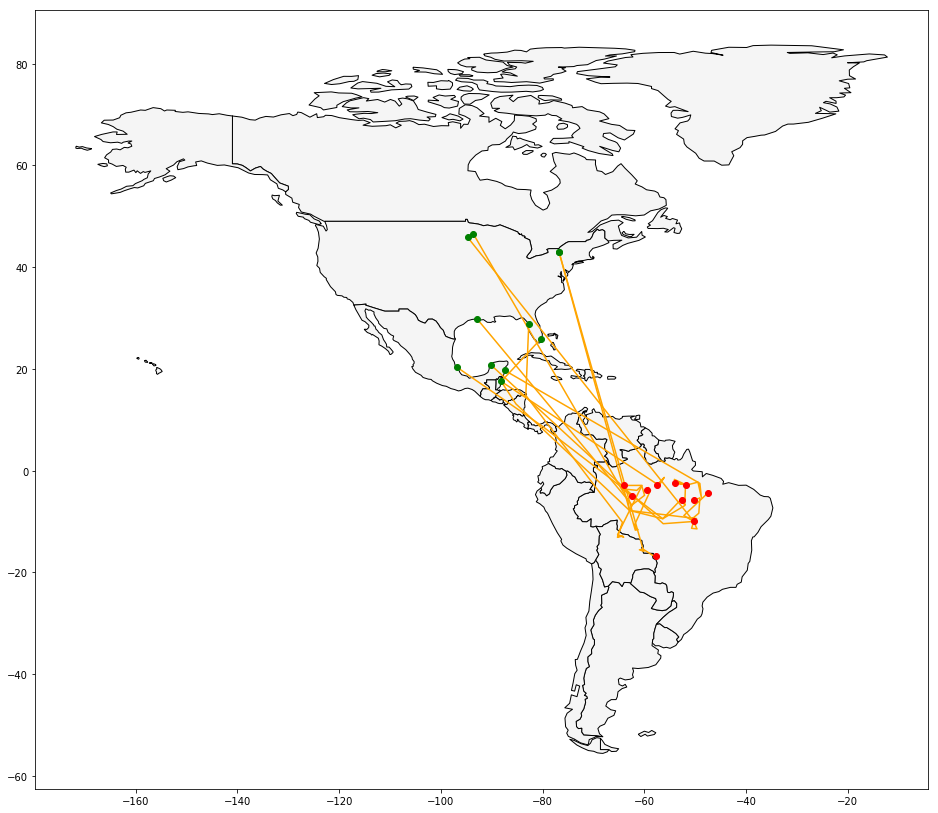

In [16]:
ax = americas.plot(color='whitesmoke', edgecolor='black', figsize=(16, 16), zorder=0)
path_gdf.plot(color='orange', ax=ax, zorder=1)
start_gdf.plot(color='green', ax=ax, zorder=2)
end_gdf.plot(color='red', ax=ax, zorder=2)

# 7. เขตรักษาพันธุ์สัตว์ป่า

โหลดข้อมูล เขตรักษาพันธุ์สัตว์ป่าของทวีปอเมริกาใต้

In [17]:
protected_filepath = f"{data_path}/SAPA_Aug2019-shapefile/SAPA_Aug2019-shapefile/SAPA_Aug2019-shapefile-polygons.shp"

protected_areas = gpd.read_file(protected_filepath)
protected_areas.head()

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,MARINE,REP_M_AREA,GIS_M_AREA,REP_AREA,GIS_AREA,NO_TAKE,NO_TK_AREA,STATUS,STATUS_YR,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,geometry
0,14067.0,14067,1,Het Spaans Lagoen,Het Spaans Lagoen,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,Not Reported,1,0.0,0.026514,0.700000,0.100194,Not Reported,0.0,Designated,1980,Not Reported,Not Reported,Not Reported,Management plan is not implemented and not ava...,State Verified,1856,Not Reported,NLD,ABW,"POLYGON ((-69.97523 12.47379, -69.97523 12.473..."
1,14003.0,14003,1,Bubali Pond Bird Sanctuary,Bubali Pond Bird Sanctuary,Bird Sanctuary,Bird Sanctuary,National,Not Reported,Not Applicable,2,0.0,0.000000,0.200000,0.582439,Not Reported,0.0,Designated,0,Not Reported,Not Reported,Not Reported,Not Reported,State Verified,1899,Not Reported,NLD,ABW,"POLYGON ((-70.04734 12.56329, -70.04615 12.563..."
2,555624439.0,555624439,1,Arikok National Park,Arikok National Park,National Park,National Park,National,Not Reported,Not Applicable,1,0.0,0.000000,34.000000,35.177714,Not Reported,0.0,Designated,2000,Non-profit organisations,Non-profit organisations,Fundacion Parke Nacional Arikok,Not Reported,State Verified,1899,Not Reported,NLD,ABW,"MULTIPOLYGON (((-69.96302 12.48384, -69.96295 ..."
3,303894.0,303894,1,Madidi,Madidi,Area Natural de Manejo Integrado,Natural Integrated Management Area,National,Not Reported,Not Applicable,0,0.0,0.000000,6035.113401,6073.960565,Not Applicable,0.0,Designated,1995,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1860,BO-L,BOL,BOL,"POLYGON ((-68.59060 -14.43388, -68.59062 -14.4..."
4,303893.0,303893,1,Apolobamba,Apolobamba,Area Natural de Manejo Integado Nacional,National Natural Integrated Management Area,National,Not Reported,Not Applicable,0,0.0,0.000000,4737.960587,4769.354411,Not Applicable,0.0,Designated,1972,Federal or national ministry or agency,Not Reported,Not Reported,Not Reported,State Verified,1860,BO-L,BOL,BOL,"POLYGON ((-69.20949 -14.73334, -69.20130 -14.7..."


โหลดแผนที่ประเทศในทวีปอเมริกาใต้ แล้วพล็อตแผนที่ เขตรักษาพันธุ์สัตว์ป่าในทวีปอเมริกาใต้ จะเห็นว่ามีเขตรักษาพันธุ์สัตว์ป่าทางทะเลด้วย

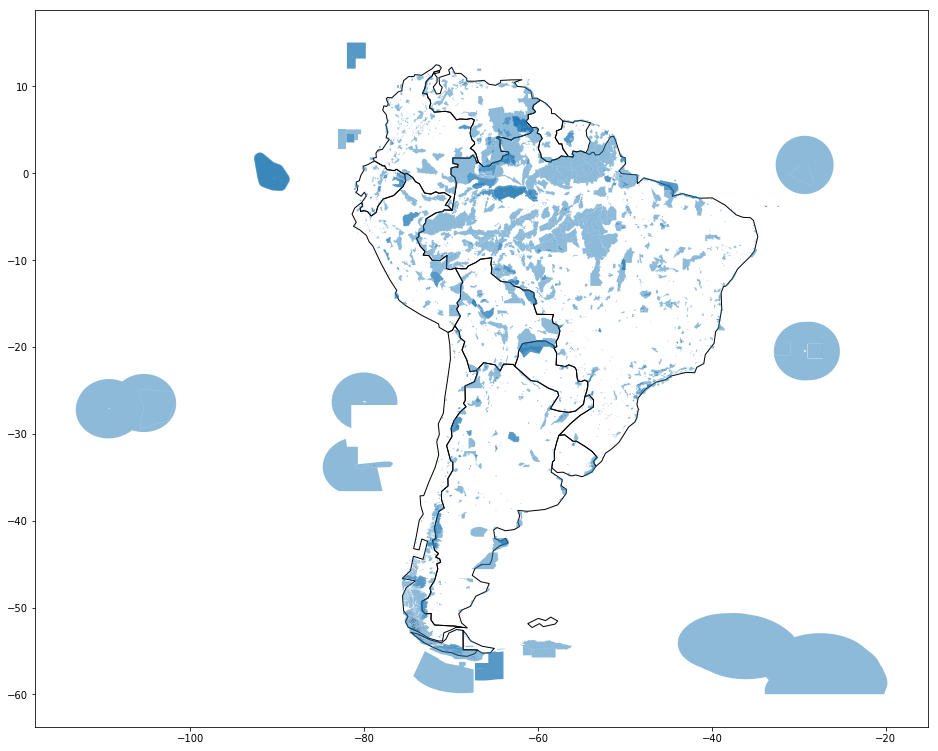

In [18]:
south_america = americas.loc[americas['continent']=='South America']

ax = south_america.plot(color='none', edgecolor='black', figsize=(16, 16), zorder=0)
protected_areas.plot(ax=ax, alpha=0.5, zorder=1)

# 8. เขตรักษาพันธุ์สัตว์ป่า ช่วยในการอนุรักษ์นก Purple Martins หรือไม่

คำนวนพื้นที่ของเขตรักษาพันธุ์สัตว์ป่าในเขตประเทศต่าง ๆ ในทวีปอเมริกาใต้

In [19]:
P_Area = sum(protected_areas['REP_AREA']-protected_areas['REP_M_AREA'])
print("South America has {} square kilometers of protected areas.".format(P_Area))

South America has 5396761.9116883585 square kilometers of protected areas.


ดูตัวอย่างข้อมูลประเทศต่าง ๆ ในทวีปอเมริกาใต้

In [20]:
south_america.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
9,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
10,17789267,South America,Chile,CHL,436100.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.63335..."
20,2931,South America,Falkland Is.,FLK,281.8,"POLYGON ((-61.20000 -51.85000, -60.00000 -51.2..."
28,3360148,South America,Uruguay,URY,73250.0,"POLYGON ((-57.62513 -30.21629, -56.97603 -30.1..."
29,207353391,South America,Brazil,BRA,3081000.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."


คำนวนว่า พื้นที่ในทวีปอเมริกาใต้ กี่เปอร์เซ็นต์ ที่เป็นเขตอนุรักษ์พันธุ์สัตว์ป่า 

In [21]:
totalArea = south_america.geometry.to_crs(epsg=3035).area.sum() / 10**6
totalArea

17759005.81506123

In [22]:
percentage_protected = P_Area/totalArea
print('Approximately {}% of South America is protected.'.format(round(percentage_protected*100, 2)))

Approximately 30.39% of South America is protected.


พล็อตว่านก Purple Martins ได้อาศัยอยู่ในบริเวณไหน ใกล้เคียงเขตรักษาพันธุ์สัตว์ป่าหรือไม่ โดยที่เราจะไม่สนใจเขตอนุรักษ์ทางทะเล `protected_areas['MARINE']!='2'`

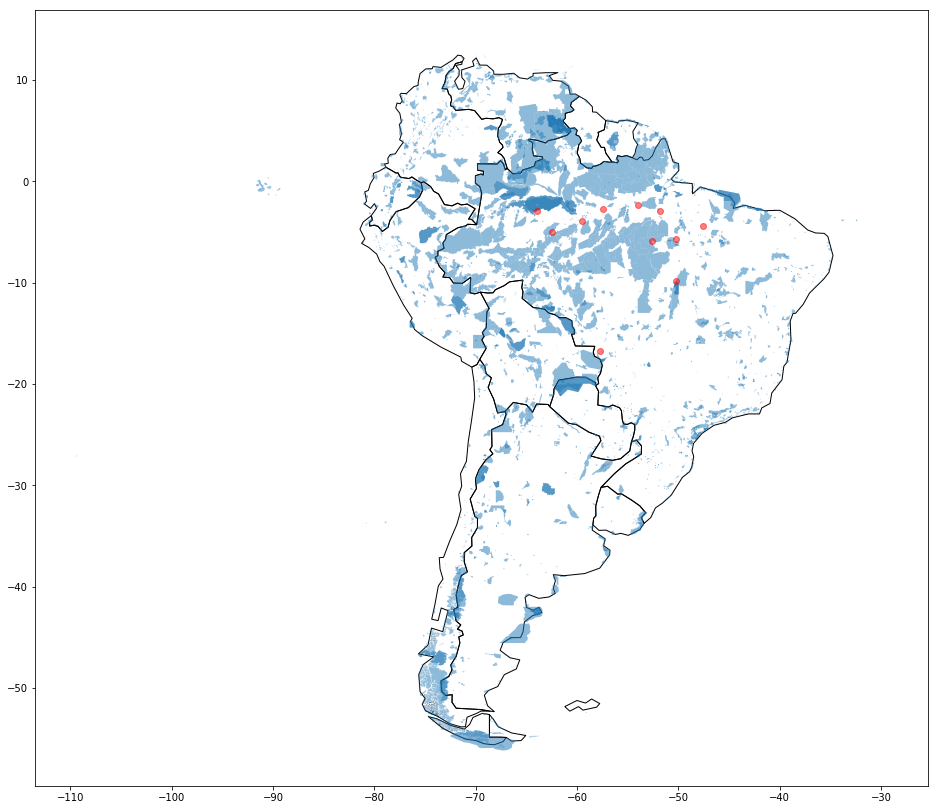

In [23]:
ax = south_america.plot(color='none', edgecolor='black', figsize=(16, 16), zorder=0)
protected_areas[protected_areas['MARINE']!='2'].plot(ax=ax, alpha=0.5)
end_gdf.plot(color='red', ax=ax, alpha=0.5)


# 7. สรุป

* 

# Credit

* https://www.kaggle.com/alexisbcook/coordinate-reference-systems
* https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
* https://www.bualabs.com/archives/751/multi-label-image-classification-satellite-imagery-deep-learning-machine-learning-image-classification-ep-5/
* http://geopandas.org/gallery/index.html